In [34]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [35]:
df = pd.read_csv('us-states.csv')

In [36]:
# Sort to choose which states to consider
# df.groupby(['state']).sum().sort_values(by=['deaths'])

States to be worked on are: Northern Mariana Islands, Virgin Islands, Guam

Texas	, California, New York

Virginia

In [37]:
California = df[df['state']=='California']
NewYork = df[df['state']=='New York']
Texas = df[df['state']=='Texas']

Virginia = df[df['state']=='Virginia']

NorthernMarianaIslands = df[df['state']=='Northern Mariana Islands']
VirginIslands= df[df['state']=='Virgin Islands']
Guam= df[df['state']=='Guam']

# Preprocessing Data

In [38]:
state = 'NorthernMarianaIslands'
cases_deaths  = NorthernMarianaIslands[['cases','deaths']].to_numpy()
# cases_deaths[:,0]= cumulative_to_daily(cases_deaths[:,0])
# cases_deaths[:,1]= cumulative_to_daily(cases_deaths[:,1])

scaler = MinMaxScaler(feature_range=(-1.0,+1.0))
cases_deaths = scaler.fit_transform(cases_deaths)

In [39]:
scaler.data_max_

array([162.,   2.])

In [40]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [41]:
cases_deaths=cases_deaths[13:] # Skip the first days where there's no data

In [42]:
window_size = 40

X,Y = convert_to_slide_window(cases_deaths,window_size)
split = int(len(X) * 0.8)

X_train,y_train=X[:split],Y[:split]
X_test,y_test =X[split:],Y[split:]

# Daily + Normalized
X_train, y_train = torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device)
X_test, y_test  = torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device)

# Load into DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train),batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False)

# Daily + Non-Normalized
y_test_inverse = scaler.inverse_transform(y_test.cpu().detach().numpy())
y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# TST Model

In [43]:
TST_model = TimeSeriesTransformer(n_features=2,d_model=128, n_heads=4, n_hidden=128, n_layers=4 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(TST_model.state_dict(), 'Weights/model_TST_{}'.format(state))
# TST_model.load_state_dict(torch.load('Weights/model_TST_{}'.format(state)))

Epoch 1 Loss is 0.7377312382062277
Epoch 2 Loss is 0.5130839712089963
Epoch 3 Loss is 0.33955982989735073
Epoch 4 Loss is 0.22574746443165672
Epoch 5 Loss is 0.15908662809265983
Epoch 6 Loss is 0.11828945328791936
Epoch 7 Loss is 0.09852079302072525
Epoch 8 Loss is 0.08514261990785599
Epoch 9 Loss is 0.0786512080166075
Epoch 10 Loss is 0.069877823193868
Epoch 11 Loss is 0.0640371044476827
Epoch 12 Loss is 0.05710093221730656
Epoch 13 Loss is 0.051595798383156456
Epoch 14 Loss is 0.04665290398730172
Epoch 15 Loss is 0.04017098248004913
Epoch 16 Loss is 0.0347773933576213
Epoch 17 Loss is 0.029694591131475236
Epoch 18 Loss is 0.02368935590816869
Epoch 19 Loss is 0.018809642539256148
Epoch 20 Loss is 0.014588584399057759
Epoch 21 Loss is 0.010656385630783107
Epoch 22 Loss is 0.007998157551305162
Epoch 23 Loss is 0.005375254614692595
Epoch 24 Loss is 0.003792456273610393
Epoch 25 Loss is 0.0026871538462324273
Epoch 26 Loss is 0.0020424416030032765
Epoch 27 Loss is 0.001761808668056296
Epoc

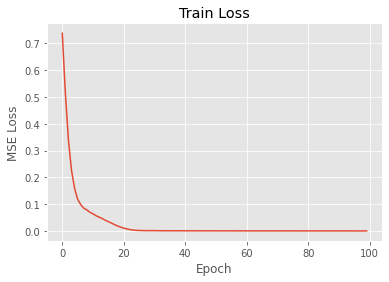

In [44]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [45]:
def test_TST(model, X):
    model.eval()
    torch.cuda.empty_cache()
    S = X.shape[1] # Sequence Length
    src_mask = model.generate_square_subsequent_mask(S)
    predicted = model(X.permute(1,0,2),None,None).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[-1,:,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print(predicted.shape)
    print('TST: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps
forecasted_TST = test_TST(TST_model, X=X_test).cpu().detach().numpy()

torch.Size([40, 68, 2])
TST: Test MSE Loss:  0.012060499750077724


In [46]:
X_train[-1].shape

torch.Size([40, 2])

In [47]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,],None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
        
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_TST = forecast_TST(TST_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward>)


In [48]:
print("We used {} Parameters for the transformer model".format(count_parameters(TST_model)))

We used 398978 Parameters for the transformer model


In [49]:
forecasted_inverse_TST = scaler.inverse_transform(forecasted_TST)

In [50]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_TST[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_TST[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_TST[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_TST[:,1]))

R2 Score for Cases 0.983570511603781
MAPE Score for Cases 0.07240569
R2 Score for Deaths 0.999947933253895
MAPE Score for Deaths 0.0035895766


# LSTM Model

In [51]:
LSTM_model = COVID_LSTM(n_hidden=128,n_features=2).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0001)
all_epochs_loss = LSTM_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(LSTM_model.state_dict(), 'Weights/model_LSTM_{}'.format(state))
# LSTM_model.load_state_dict(torch.load('Weights/model_LSTM_{}'.format(state)))

Epoch 1 Loss is 0.5579878158039517
Epoch 2 Loss is 0.5149230592780643
Epoch 3 Loss is 0.46710602773560417
Epoch 4 Loss is 0.4102385838826497
Epoch 5 Loss is 0.3340100281768375
Epoch 6 Loss is 0.22454501026206547
Epoch 7 Loss is 0.13210144970152113
Epoch 8 Loss is 0.1096761210097207
Epoch 9 Loss is 0.10627848406632741
Epoch 10 Loss is 0.10867719766166475
Epoch 11 Loss is 0.10457622177071041
Epoch 12 Loss is 0.10115237451261944
Epoch 13 Loss is 0.10122733563184738
Epoch 14 Loss is 0.10051020814312829
Epoch 15 Loss is 0.09072918444871902
Epoch 16 Loss is 0.07049403629369205
Epoch 17 Loss is 0.032389178665147886
Epoch 18 Loss is 0.008777390958534347
Epoch 19 Loss is 0.007515870759056674
Epoch 20 Loss is 0.004237961347421838
Epoch 21 Loss is 0.0035825210571702984
Epoch 22 Loss is 0.0028104325368379555
Epoch 23 Loss is 0.0020695449396347008
Epoch 24 Loss is 0.0018764878235136468
Epoch 25 Loss is 0.0013522939989343286
Epoch 26 Loss is 0.0011382237231979768
Epoch 27 Loss is 0.00098373908420196

In [52]:
def test_LSTM(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('LSTM: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_LSTM = test_LSTM(LSTM_model, X=X_test).cpu().detach().numpy()

LSTM: Test MSE Loss:  0.0332820750772953


In [53]:
X_test.shape

torch.Size([68, 40, 2])

In [54]:
def forecast_LSTM(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_LSTM = forecast_LSTM(LSTM_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward>)


In [55]:
forecasted_inverse_LSTM = scaler.inverse_transform(forecasted_LSTM)

In [56]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_LSTM[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_LSTM[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_LSTM[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_LSTM[:,1]))

R2 Score for Cases 0.9552465115187613
MAPE Score for Cases 0.121051006
R2 Score for Deaths 0.999995260222321
MAPE Score for Deaths 0.0010754791


# GRU Model

In [57]:
GRU_model = COVID_GRU(n_hidden=128,n_features=2).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.0001)
all_epochs_loss = GRU_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(GRU_model.state_dict(), 'Weights/model_GRU_{}'.format(state))
# GRU_model.load_state_dict(torch.load('Weights/model_GRU_{}'.format(state)))

Epoch 1 Loss is 0.5806553694936964
Epoch 2 Loss is 0.45651258362664116
Epoch 3 Loss is 0.3368220759762658
Epoch 4 Loss is 0.23121530479855007
Epoch 5 Loss is 0.14981300632158914
Epoch 6 Loss is 0.10854919006427129
Epoch 7 Loss is 0.08727383448017968
Epoch 8 Loss is 0.0759000000026491
Epoch 9 Loss is 0.06496767575542133
Epoch 10 Loss is 0.04882190666264958
Epoch 11 Loss is 0.03207785284353627
Epoch 12 Loss is 0.014566659203006161
Epoch 13 Loss is 0.004070627270266414
Epoch 14 Loss is 0.0022017735496370327
Epoch 15 Loss is 0.0023255072818655106
Epoch 16 Loss is 0.001703460467979312
Epoch 17 Loss is 0.0013406259887334374
Epoch 18 Loss is 0.0012700023103712334
Epoch 19 Loss is 0.0011749880310768883
Epoch 20 Loss is 0.0011161000648927358
Epoch 21 Loss is 0.0010181888873274955
Epoch 22 Loss is 0.0009532376425340772
Epoch 23 Loss is 0.000917036092788395
Epoch 24 Loss is 0.0008900543002204762
Epoch 25 Loss is 0.0008926083941736983
Epoch 26 Loss is 0.000846650056903147
Epoch 27 Loss is 0.000801

In [58]:
def test_GRU(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('GRU: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_GRU = test_GRU(GRU_model, X=X_test).cpu().detach().numpy()

GRU: Test MSE Loss:  0.017256010323762894


In [59]:
X_test.shape

torch.Size([68, 40, 2])

In [60]:
def forecast_GRU(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_GRU = forecast_GRU(GRU_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.0563, device='cuda:0', grad_fn=<MseLossBackward>)


In [61]:
forecasted_inverse_GRU = scaler.inverse_transform(forecasted_GRU)

In [62]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_GRU[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_GRU[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_GRU[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_GRU[:,1]))

R2 Score for Cases 0.9737629851147906
MAPE Score for Cases 0.08998872
R2 Score for Deaths 0.999962820525943
MAPE Score for Deaths 0.0030964236


# Plots

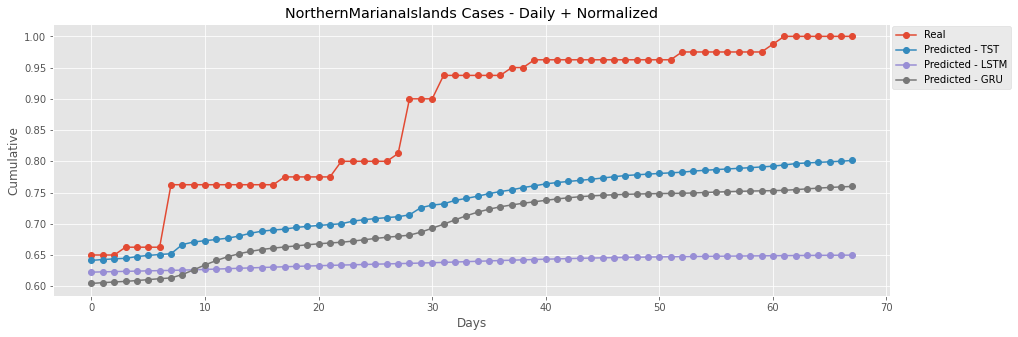

In [63]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,0].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,0],label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} Cases - Daily + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

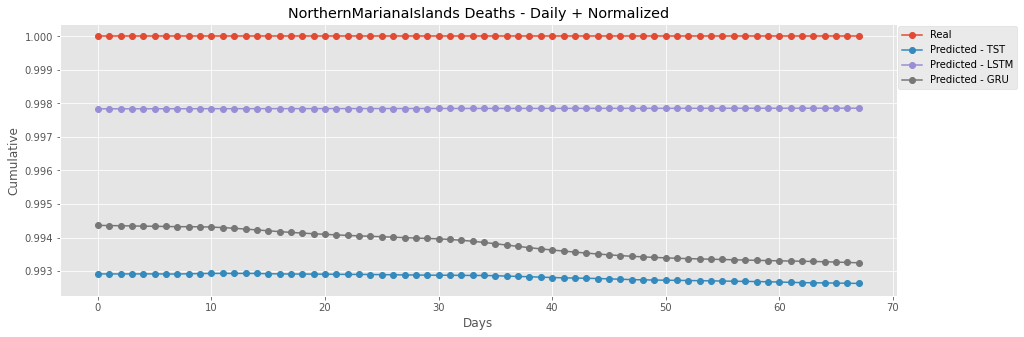

In [64]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,1].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,1],label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,1],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,1],label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,1].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Deaths - Daily + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

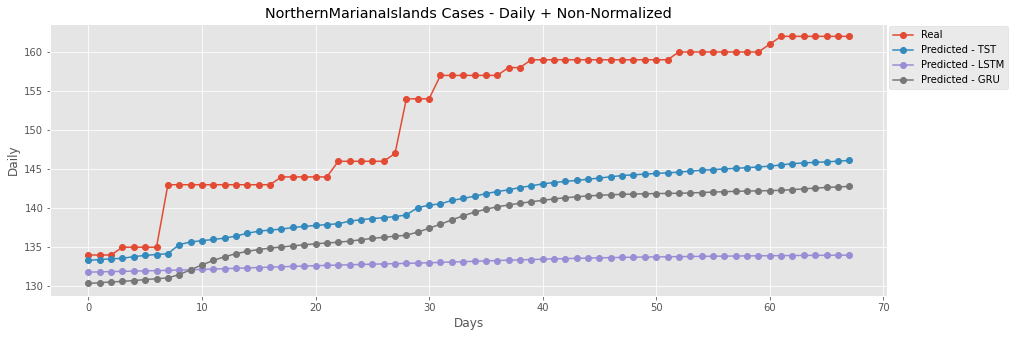

In [65]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,0],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,0],label='Predicted - GRU',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Cases - Daily + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Daily')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

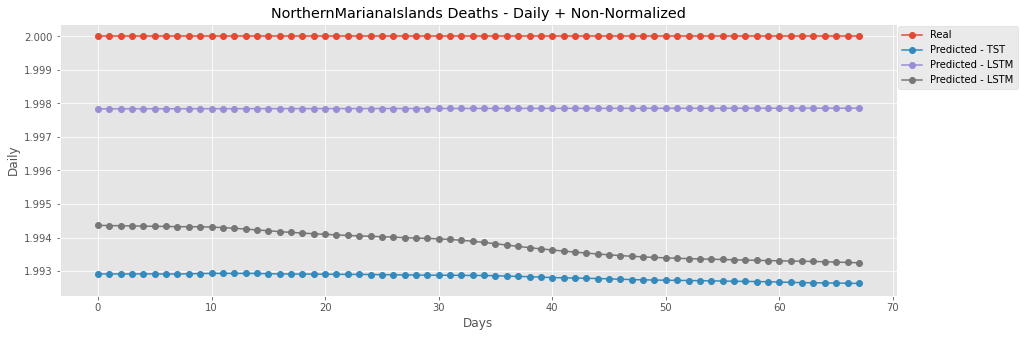

In [66]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,1],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,1],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,1],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,1],label='Predicted - LSTM',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Deaths - Daily + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Daily')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()